# Лабораторная работа 9  
## Стохастическая синхронизация
Выполнила: Шаповалова Виктория, ИКТ-11М.  

### 1. Импорт библиотек  
В данном разделе импортируются библиотеки, которые будут использоваться в ходе выполнения работы.

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import QAMModem
from scipy import signal
from scipy.fftpack import fft, ifft, fftfreq

### 2. LSFR  
В лабораторной работе требуется реализовать схему скремблера-дескремблера. Для этого требуется реализовать блок регистра сдвига с линейной обратной связью (LFSR). В его основе лежит генераторный полином, по которому определяются отводы LFSR. 

In [63]:
def lfsr(gen_poly, current_state):
   
    gen_poly_array = np.zeros(np.max(gen_poly) + 1, dtype=int)
    gen_poly_array[gen_poly] = 1
    
    out_bit = current_state[-1]
    next_state = np.bitwise_xor(
        np.roll(current_state, 1),
        np.hstack([0, out_bit * gen_poly_array[1:-1]])
    )
    return out_bit, next_state

### 3. Генератор M-последовательности
Далее применена разработанная функция LSFR для генерации m-последовательности. В качестве порождающего полинома взят многочлен x^5 + x^3 + 1. Начальное состояние [0,0,0,0,1]. Длина последовательности составляет 2 в степени генераторного полинома минус 1. Большее значение приводит к зацикливанию.

Выходная последовательность максимальной длины:
 [1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]

Последовательность состояний регистров сдвига в LFSR:
 [[1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 1. 1.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1.]
 [1

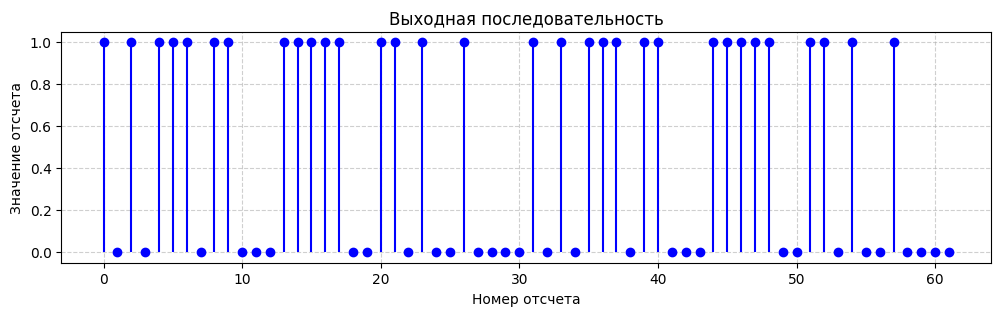

In [64]:
# Параметры LFSR
gen_poly = np.array([5, 3, 0]) 
init_state = np.array(np.hstack([np.zeros(np.max(gen_poly) - 1), 1]), dtype=int) 

# Генерация последовательности
sequence_length = 2 * (2**np.max(gen_poly) - 1)
out = np.zeros(sequence_length)
state_lfsr = np.zeros((sequence_length, len(init_state)))

current_state = init_state.copy()
for i in range(sequence_length):
    out[i], current_state = lfsr(gen_poly, current_state)
    state_lfsr[i, :] = current_state

print('Выходная последовательность максимальной длины:\n', out)
print('\nПоследовательность состояний регистров сдвига в LFSR:\n', state_lfsr)

plt.figure(figsize=(12, 3))

plt.stem(out, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title('Выходная последовательность')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)


Вычислена автокорреляция m-последовательности. Она соответствует ожидаемой - имеет один четкий центрированный пик с низким уровнем боковых пиков. 

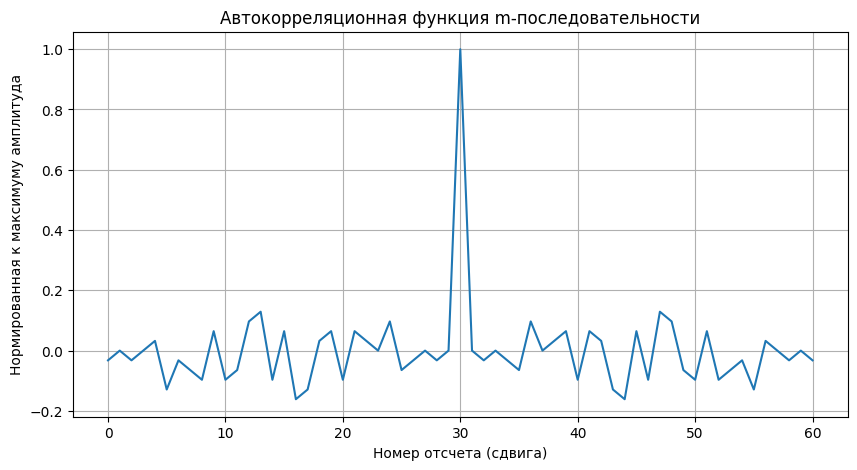

In [65]:
m_sequence = out[0:2**np.max(gen_poly) - 1]
acf = np.correlate(1 - 2*m_sequence, 1 - 2*m_sequence, mode='full')
acf = acf / np.max(acf)

plt.figure(figsize=(10, 5))
plt.plot(acf)
plt.grid()
plt.title('Автокорреляционная функция m-последовательности')
plt.xlabel('Номер отсчета (сдвига)')
plt.ylabel('Нормированная к максимуму амплитуда')
plt.show()

### 4. Скремблер-дескремблер
Далее генерация m-последовательности применена для создания скремблера-дескремблера.   
Скремблер применяется к передаваемой последовательности для представления ее в виде псевдослучайной последовательности, которая не будет иметь длинных последовательностей нулей или единиц. Это свойство полезно, поскольку упрощает тактовую синхронизацию, а также делает сигнал менее подверженным узкополосным помехам. 

In [66]:
def scrambler_descrambler(gen_poly, init_state, data_array):

    current_state = init_state.copy()
    out_data = np.zeros_like(data_array, dtype=int)
    
    for i in range(len(data_array)):

        lfsr_bit, current_state = lfsr(gen_poly, current_state)
        out_data[i] = int(data_array[i]) ^ int(lfsr_bit)
    
    return out_data

Далее функция применена с учетом генерации m-последовательности. Случайная последовательность поступает на вход скремблера, а затем дескремблера. Исходная последовательность полностью совпала с восстановленной, что говорит о корректной работе соединенных последовательно скремблера и дескремблера.

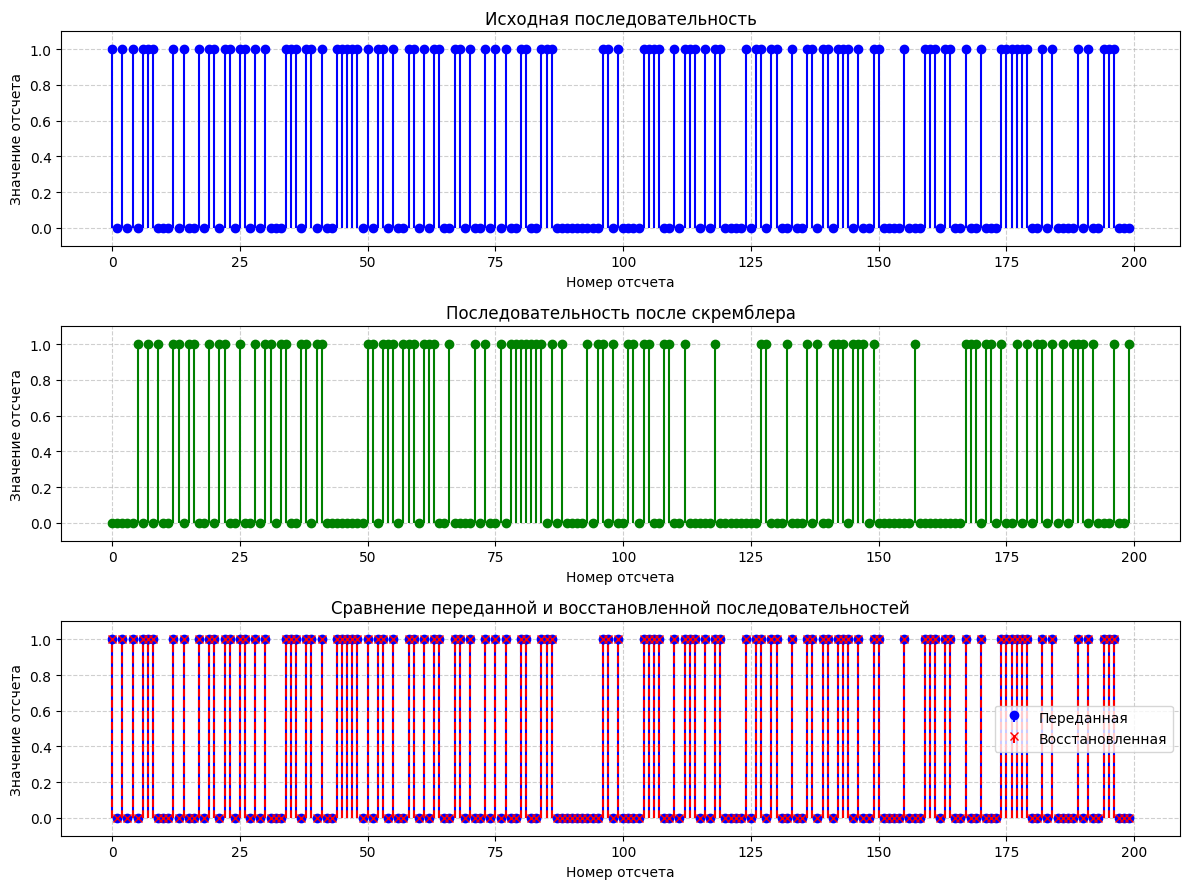

In [67]:
gen_poly = np.array([5, 3, 0])  
init_state = np.array(np.hstack([np.zeros(np.max(gen_poly) - 1), 1]), dtype=int)  

data = np.random.randint(0, 2, 200)

scrambled_data = scrambler_descrambler(gen_poly, init_state, data)
descrambled_data = scrambler_descrambler(gen_poly, init_state, scrambled_data)

plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title('Исходная последовательность')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)

plt.subplot(3, 1, 2)
plt.stem(scrambled_data, linefmt='g-', markerfmt='go', basefmt=' ')
plt.title('Последовательность после скремблера')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)

plt.subplot(3, 1, 3)
plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ', label='Переданная')
plt.stem(descrambled_data, linefmt='r--', markerfmt='rx', basefmt=' ', label='Восстановленная')
plt.title('Сравнение переданной и восстановленной последовательностей')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

### 5. Исследование зависимости от генераторного полинома
Была исследована зависимость результатов скремблирования от выбора генераторного полинома. Для этого были получены автокорреляции и спектры для случаев с генераторами [5, 3, 0], [5, 1, 0], [5, 4, 3, 2, 0].

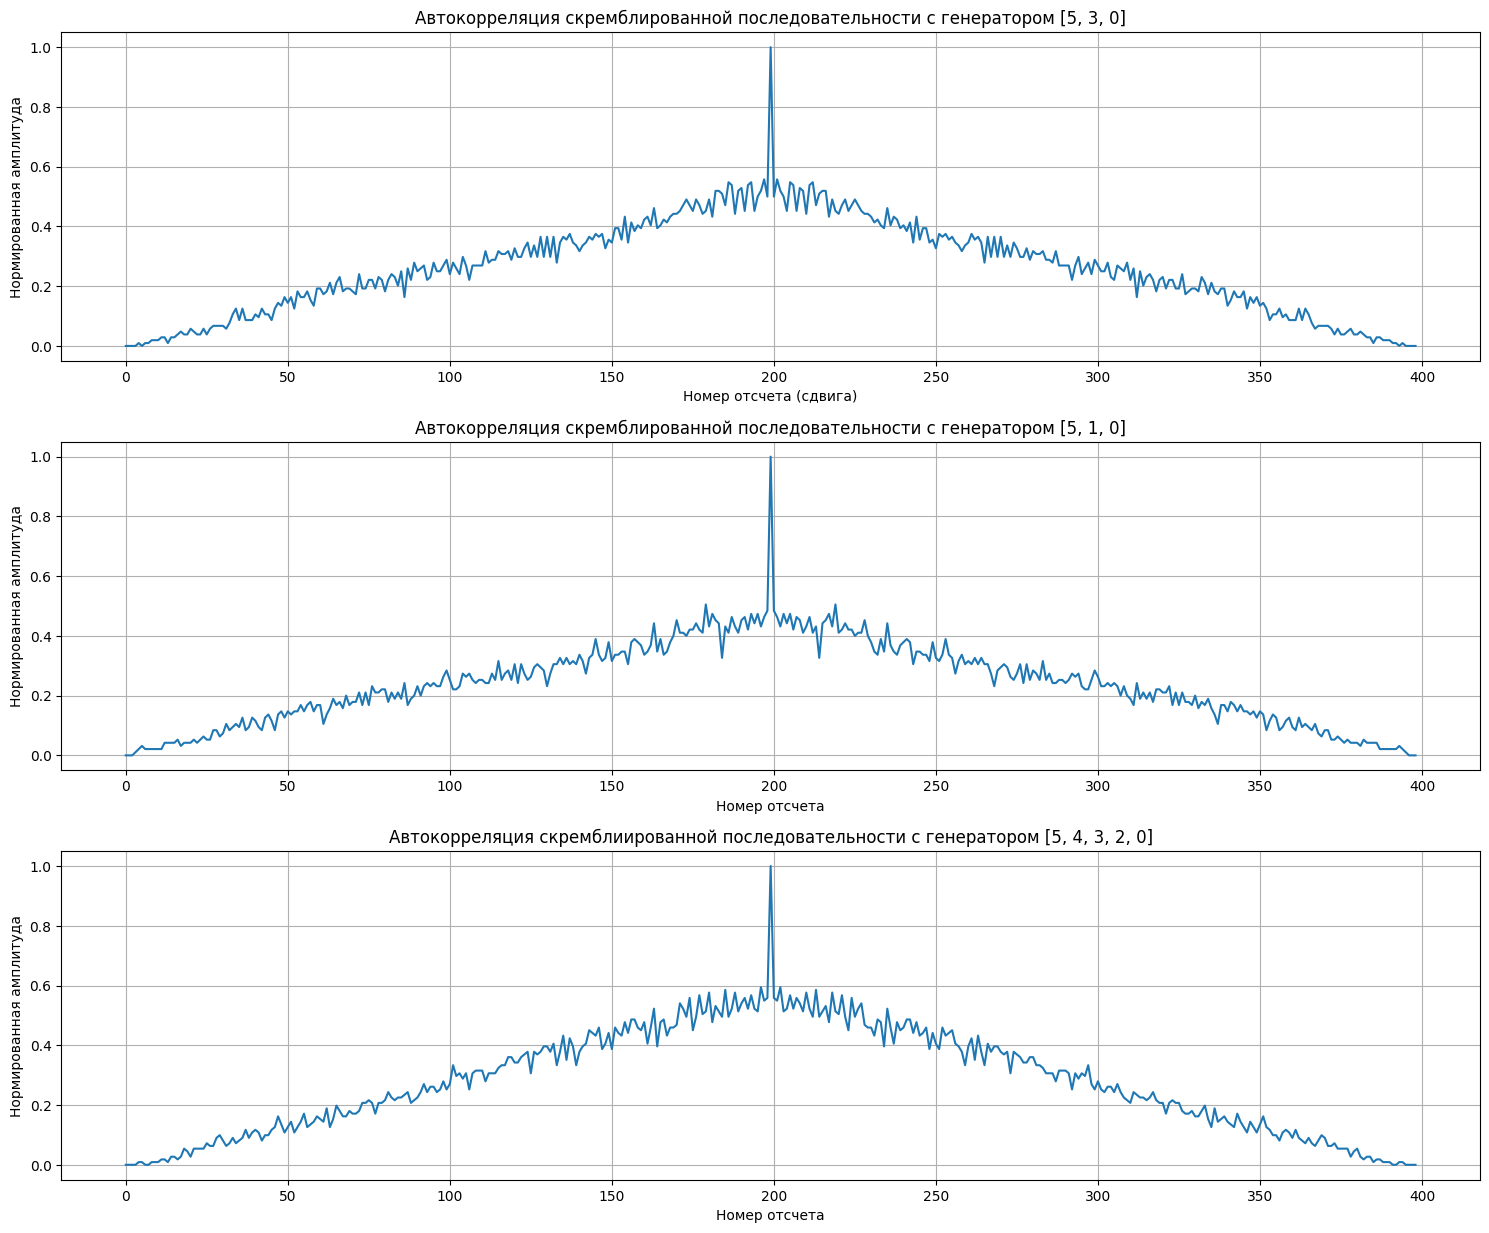

<Figure size 640x480 with 0 Axes>

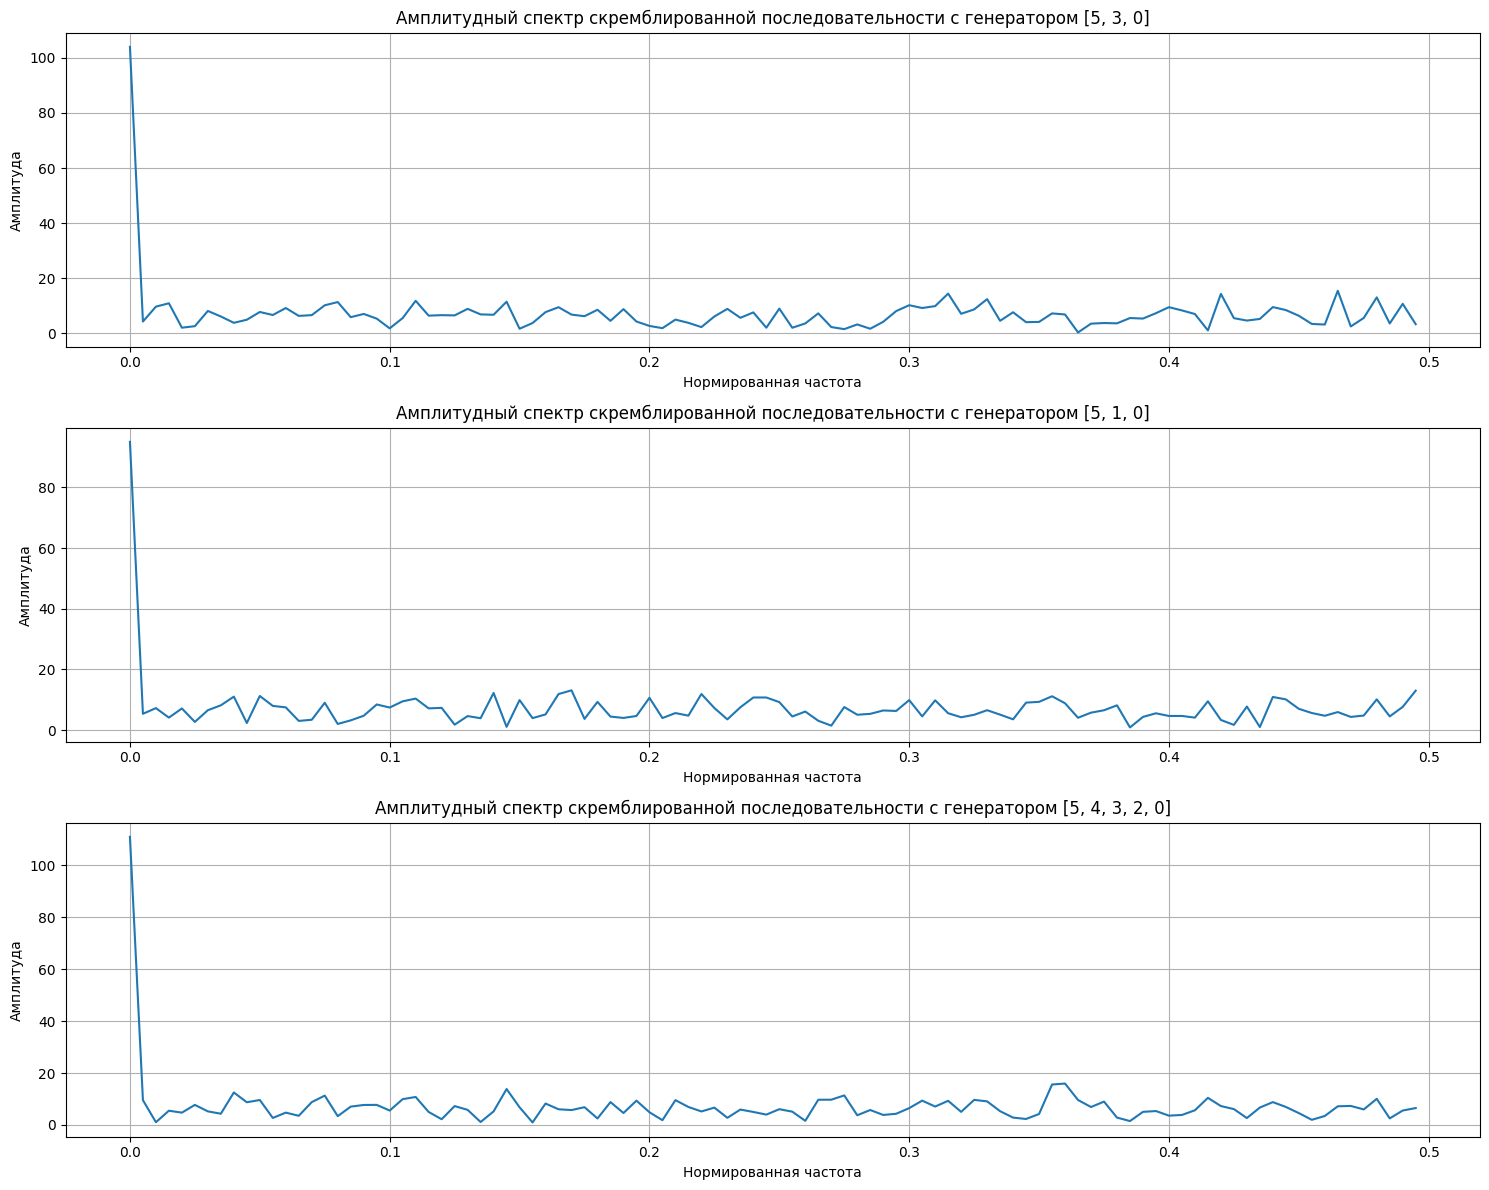

In [68]:
gen_poly = np.array([5, 3, 0])
gen_poly_1 = np.array([5, 1, 0])
gen_poly_2 = np.array([5, 4, 3, 2, 0])

init_state = np.array(np.hstack([np.zeros(np.max(gen_poly) - 1), 1]), dtype=int)  
init_state_1 = np.array(np.hstack([np.zeros(np.max(gen_poly_1) - 1), 1]), dtype=int)  
init_state_2 = np.array(np.hstack([np.zeros(np.max(gen_poly_2) - 1), 1]), dtype=int)  

data = np.random.randint(0, 2, 200)

scrambled_data = scrambler_descrambler(gen_poly, init_state, data)
scrambled_data_1 = scrambler_descrambler(gen_poly_1, init_state_1, data)
scrambled_data_2 = scrambler_descrambler(gen_poly_2, init_state_2, data)

acf = np.correlate(scrambled_data, scrambled_data, mode='full')
acf = acf / np.max(acf)

acf_1 = np.correlate(scrambled_data_1, scrambled_data_1, mode='full')
acf_1 = acf_1 / np.max(acf_1)

acf_2 = np.correlate(scrambled_data_2, scrambled_data_2, mode='full')
acf_2 = acf_2 / np.max(acf_2)



plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(acf)
plt.grid()
plt.title('Автокорреляция скремблированной последовательности с генератором [5, 3, 0]')
plt.xlabel('Номер отсчета (сдвига)')
plt.ylabel('Нормированная амплитуда')
plt.tight_layout()


plt.subplot(3, 1, 2)
plt.plot(acf_1)
plt.grid()
plt.title('Автокорреляция скремблированной последовательности с генератором [5, 1, 0]')
plt.xlabel('Номер отсчета')
plt.ylabel('Нормированная амплитуда')
plt.tight_layout()

plt.subplot(3, 1, 3)
plt.plot(acf_2)
plt.grid()
plt.title('Автокорреляция скремблиированной последовательности с генератором [5, 4, 3, 2, 0]')
plt.xlabel('Номер отсчета')
plt.ylabel('Нормированная амплитуда')
plt.show()


plt.tight_layout()
plt.show()

S = abs(fft(scrambled_data))
xf = fftfreq(np.size(scrambled_data))

S_1 = abs(fft(scrambled_data_1))
xf_1 = fftfreq(np.size(scrambled_data_1))

S_2 = abs(fft(scrambled_data_2))
xf_2 = fftfreq(np.size(scrambled_data_2))

plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(xf[:len(xf)//2], S[:len(xf)//2])
plt.title("Амплитудный спектр скремблированной последовательности с генератором [5, 3, 0]")
plt.xlabel("Нормированная частота")
plt.ylabel("Амплитуда")
plt.grid()
plt.tight_layout()

plt.subplot(3, 1, 2)
plt.plot(xf_1[:len(xf_1)//2], S_1[:len(xf_1)//2])
plt.title("Амплитудный спектр скремблированной последовательности с генератором [5, 1, 0]")
plt.xlabel("Нормированная частота")
plt.ylabel("Амплитуда")
plt.grid()
plt.tight_layout()

plt.subplot(3, 1, 3)
plt.plot(xf_2[:len(xf_2)//2], S_2[:len(xf_2)//2])
plt.title("Амплитудный спектр скремблированной последовательности с генератором [5, 4, 3, 2, 0]")
plt.xlabel("Нормированная частота")
plt.ylabel("Амплитуда")
plt.grid()
plt.tight_layout()
plt.show()

Полученные результаты показывают, что для приведенных генераторов полученные результаты не имеют значительных отличий. Полином [5,1,0] имеет наибольшие колебания в спектре при наименьшей амплитуде основного пика, а также обладает худшей автокорреляцией из промоделированных, поскольку имеет неудачное разнесение тапов. Полином [5,4,3,2,0] схож по результатам с [5,3,0], однако имеет большее количество тапов и более сложен в реализации. Таким образом, оптимальным является выбор [5,3,0] в качестве генератора.

### 6. Сравнение результатов для двух разных последовательностей  
Было проведено сравнение результатов для случайной последовательности 0 и 1 и для последовательности с большими последовательными блоками нулей и единиц.

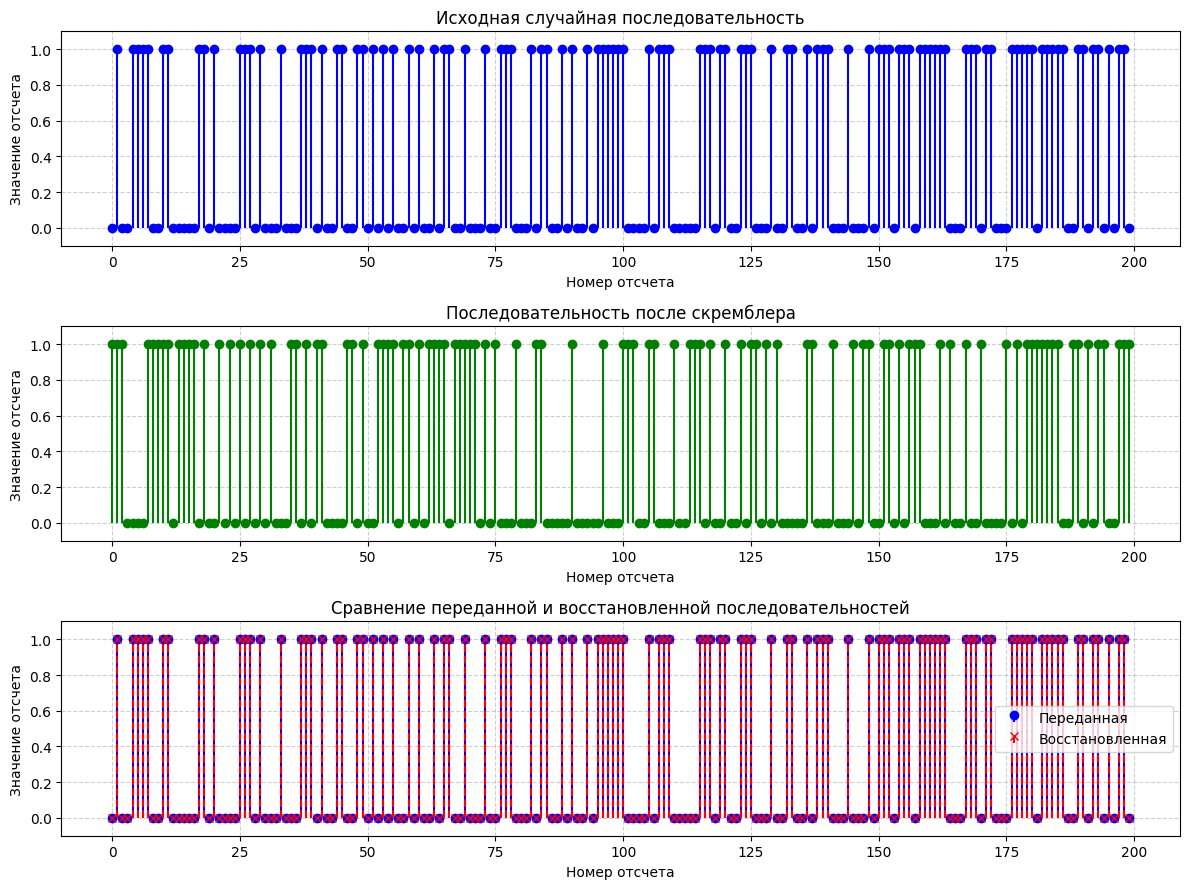

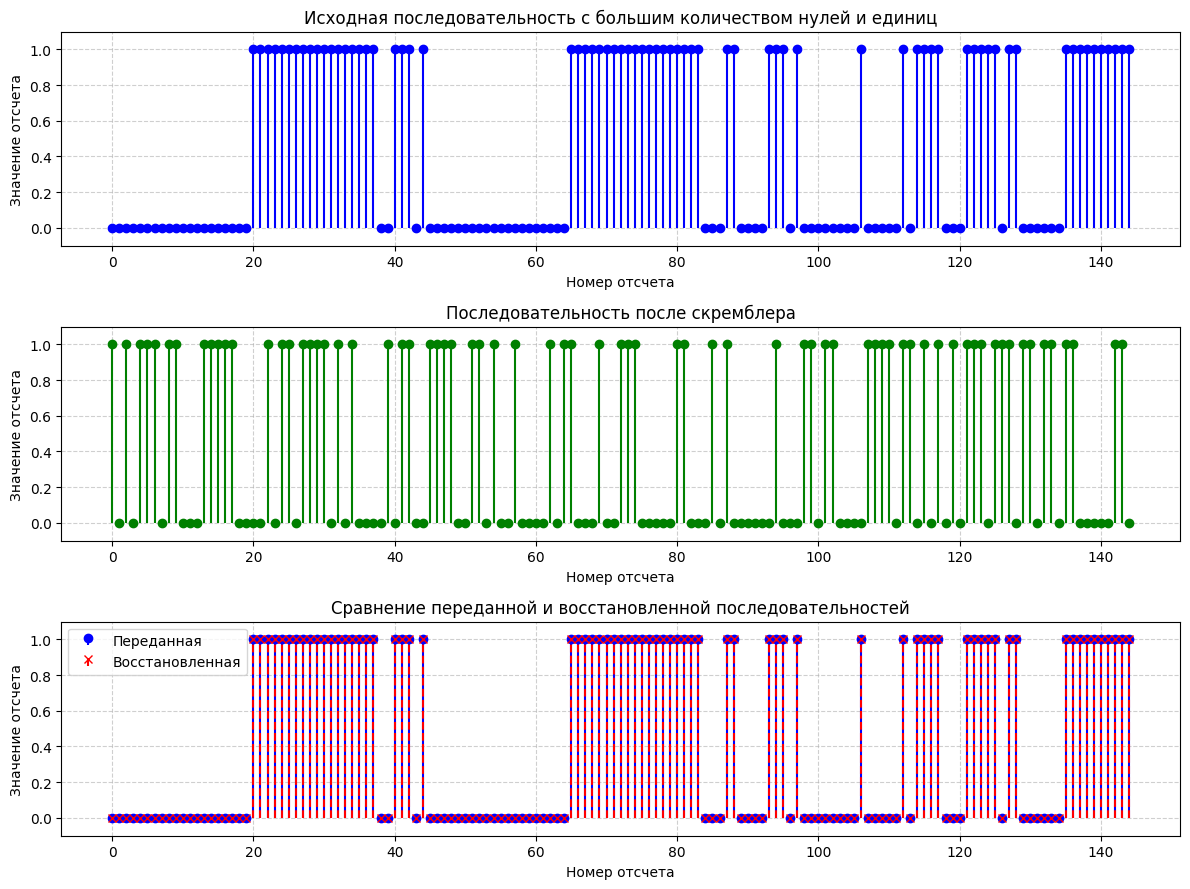

In [69]:
gen_poly = np.array([5, 3, 0])  
init_state = np.array(np.hstack([np.zeros(np.max(gen_poly) - 1), 1]), dtype=int)  

data = np.random.randint(0, 2, 200)

block_zeros = np.zeros(20, dtype=int)  # Блок из 20 нулей
block_ones = np.ones(15, dtype=int)    # Блок из 15 единиц
random_part = np.random.randint(0, 2, 50)  # Случайные биты


data_2 = np.concatenate([
    block_zeros,
    block_ones,
    np.random.randint(0, 2, 10),  
    block_zeros,
    block_ones,
    random_part,
    block_zeros[-5:],  
    np.ones(10)        
])[:200]  

scrambled_data = scrambler_descrambler(gen_poly, init_state, data)
descrambled_data = scrambler_descrambler(gen_poly, init_state, scrambled_data)
  
scrambled_data_2 = scrambler_descrambler(gen_poly, init_state, data_2)
descrambled_data_2 = scrambler_descrambler(gen_poly, init_state, scrambled_data_2)

plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title('Исходная случайная последовательность')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)

plt.subplot(3, 1, 2)
plt.stem(scrambled_data, linefmt='g-', markerfmt='go', basefmt=' ')
plt.title('Последовательность после скремблера')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)

plt.subplot(3, 1, 3)
plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ', label='Переданная')
plt.stem(descrambled_data, linefmt='r--', markerfmt='rx', basefmt=' ', label='Восстановленная')
plt.title('Сравнение переданной и восстановленной последовательностей')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.stem(data_2, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title('Исходная последовательность с большим количеством нулей и единиц')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)

plt.subplot(3, 1, 2)
plt.stem(scrambled_data_2, linefmt='g-', markerfmt='go', basefmt=' ')
plt.title('Последовательность после скремблера')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-0.1, 1.1)

plt.subplot(3, 1, 3)
plt.stem(data_2, linefmt='b-', markerfmt='bo', basefmt=' ', label='Переданная')
plt.stem(descrambled_data_2, linefmt='r--', markerfmt='rx', basefmt=' ', label='Восстановленная')
plt.title('Сравнение переданной и восстановленной последовательностей')
plt.xlabel('Номер отсчета')
plt.ylabel('Значение отсчета')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

Результаты показывают, что скремблер-дескремблер одинаково хорошо работает со случайной последовательностью и с последовательностью с большим количеством последовательных нулей и единиц.

### 7. Исследование зависимости от шума 
Блоки скремблера-дескремблера были добавлены к системе с модуляцией BPSK и каналом AWGN. Полученная система была исследована при разном значении сигнал-шум.

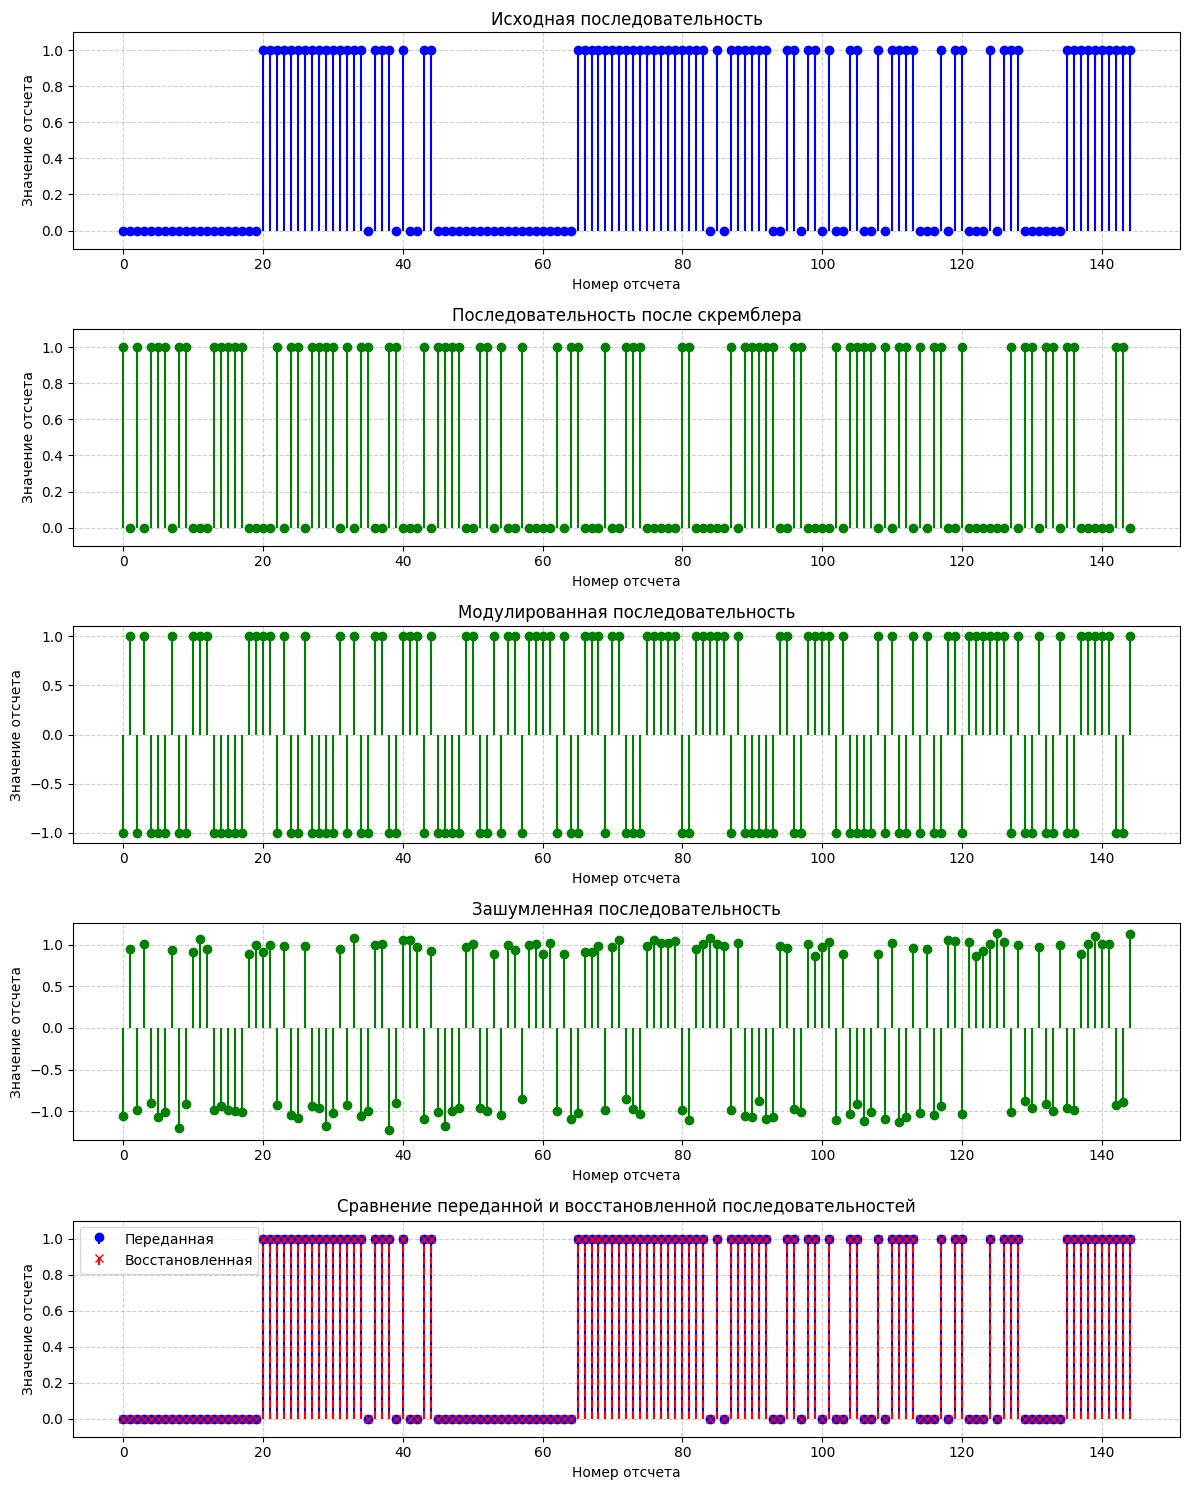

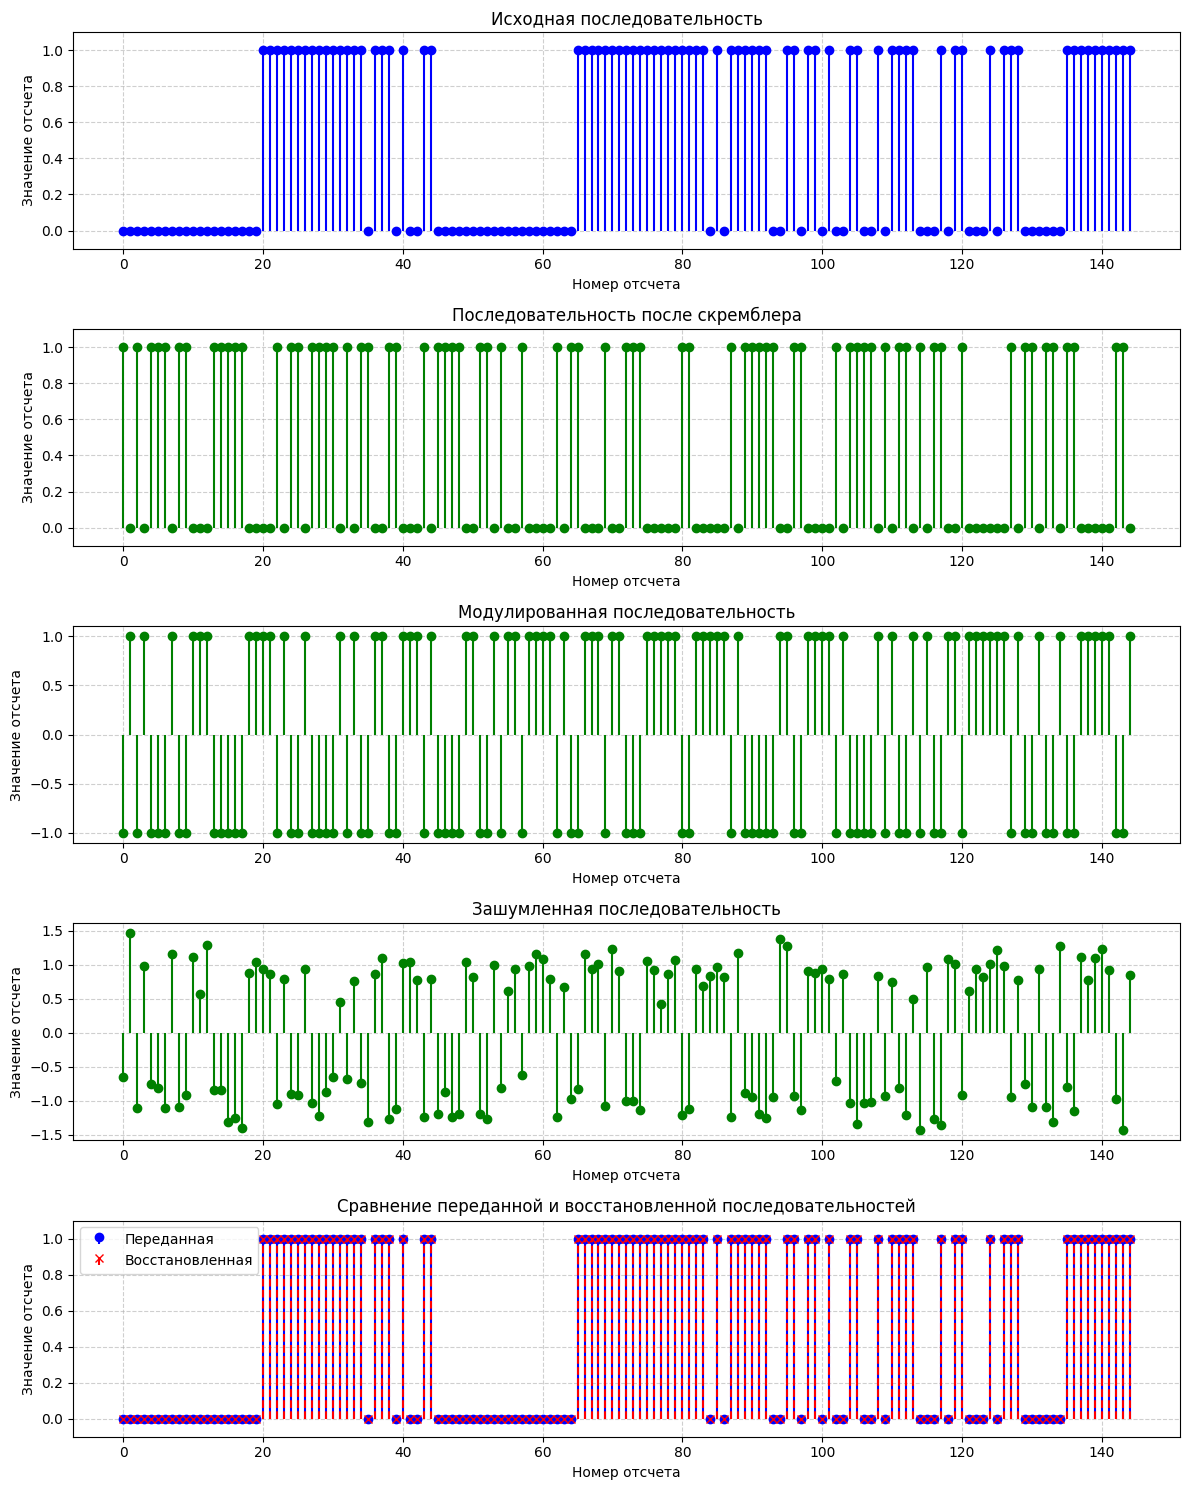

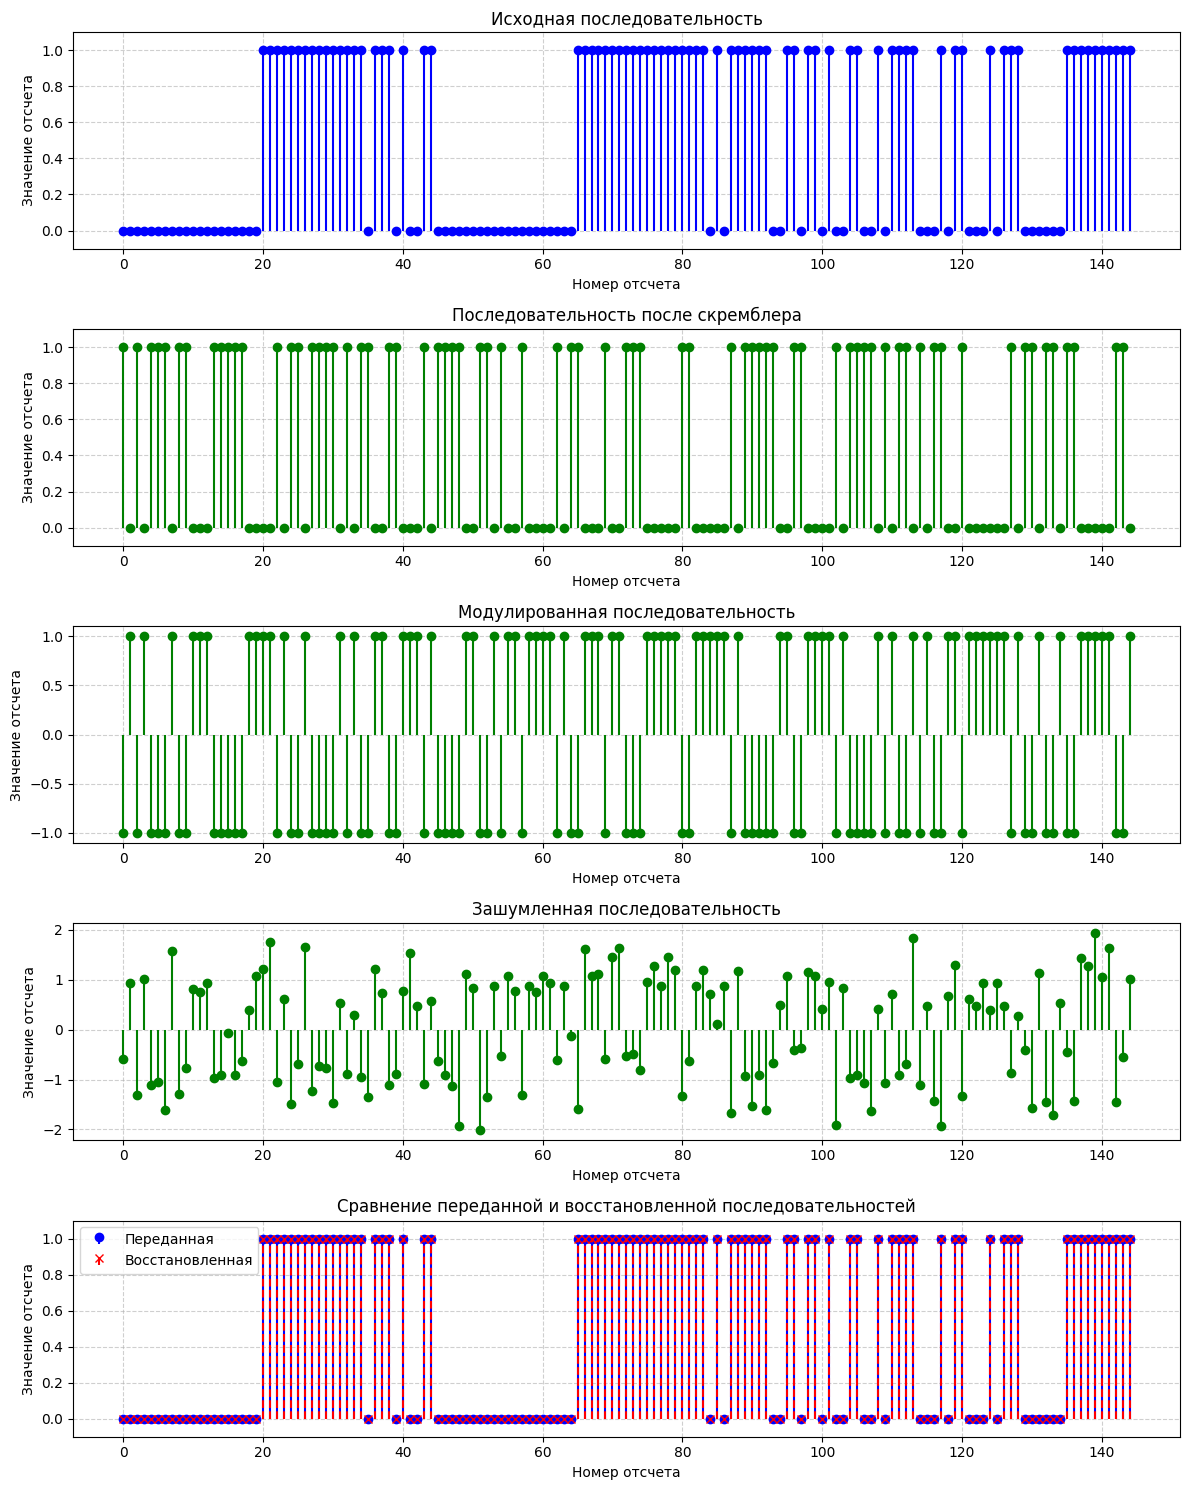

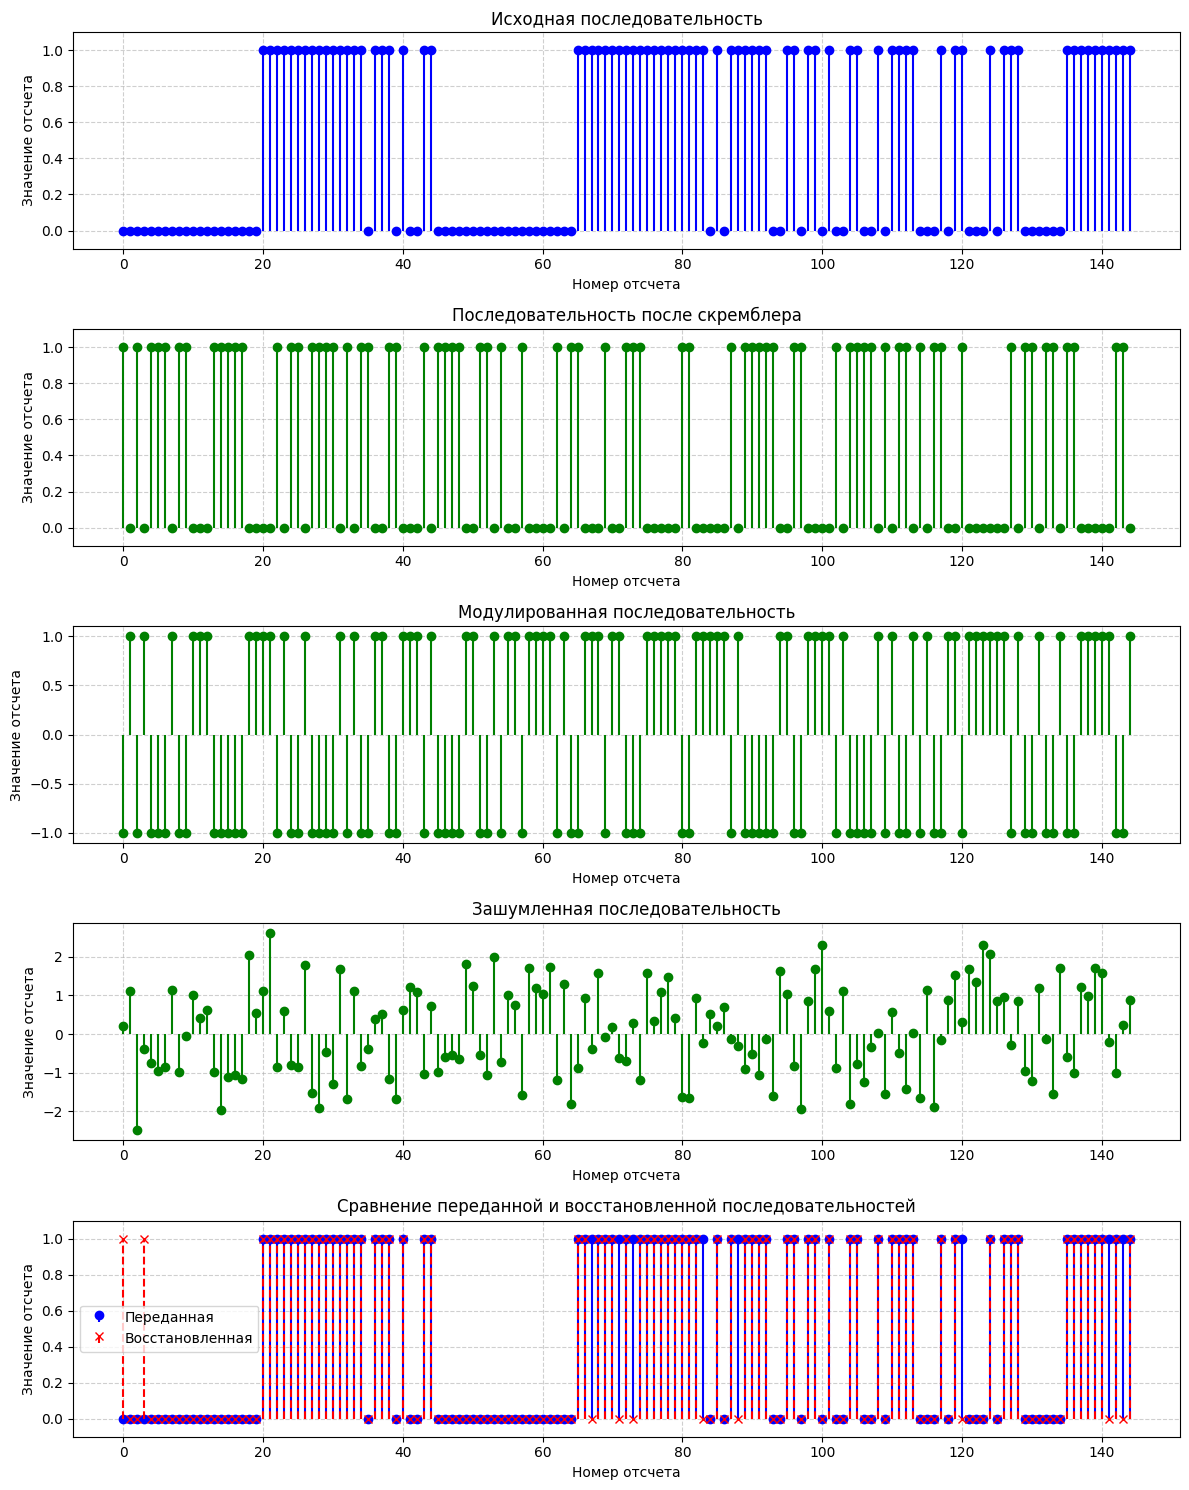

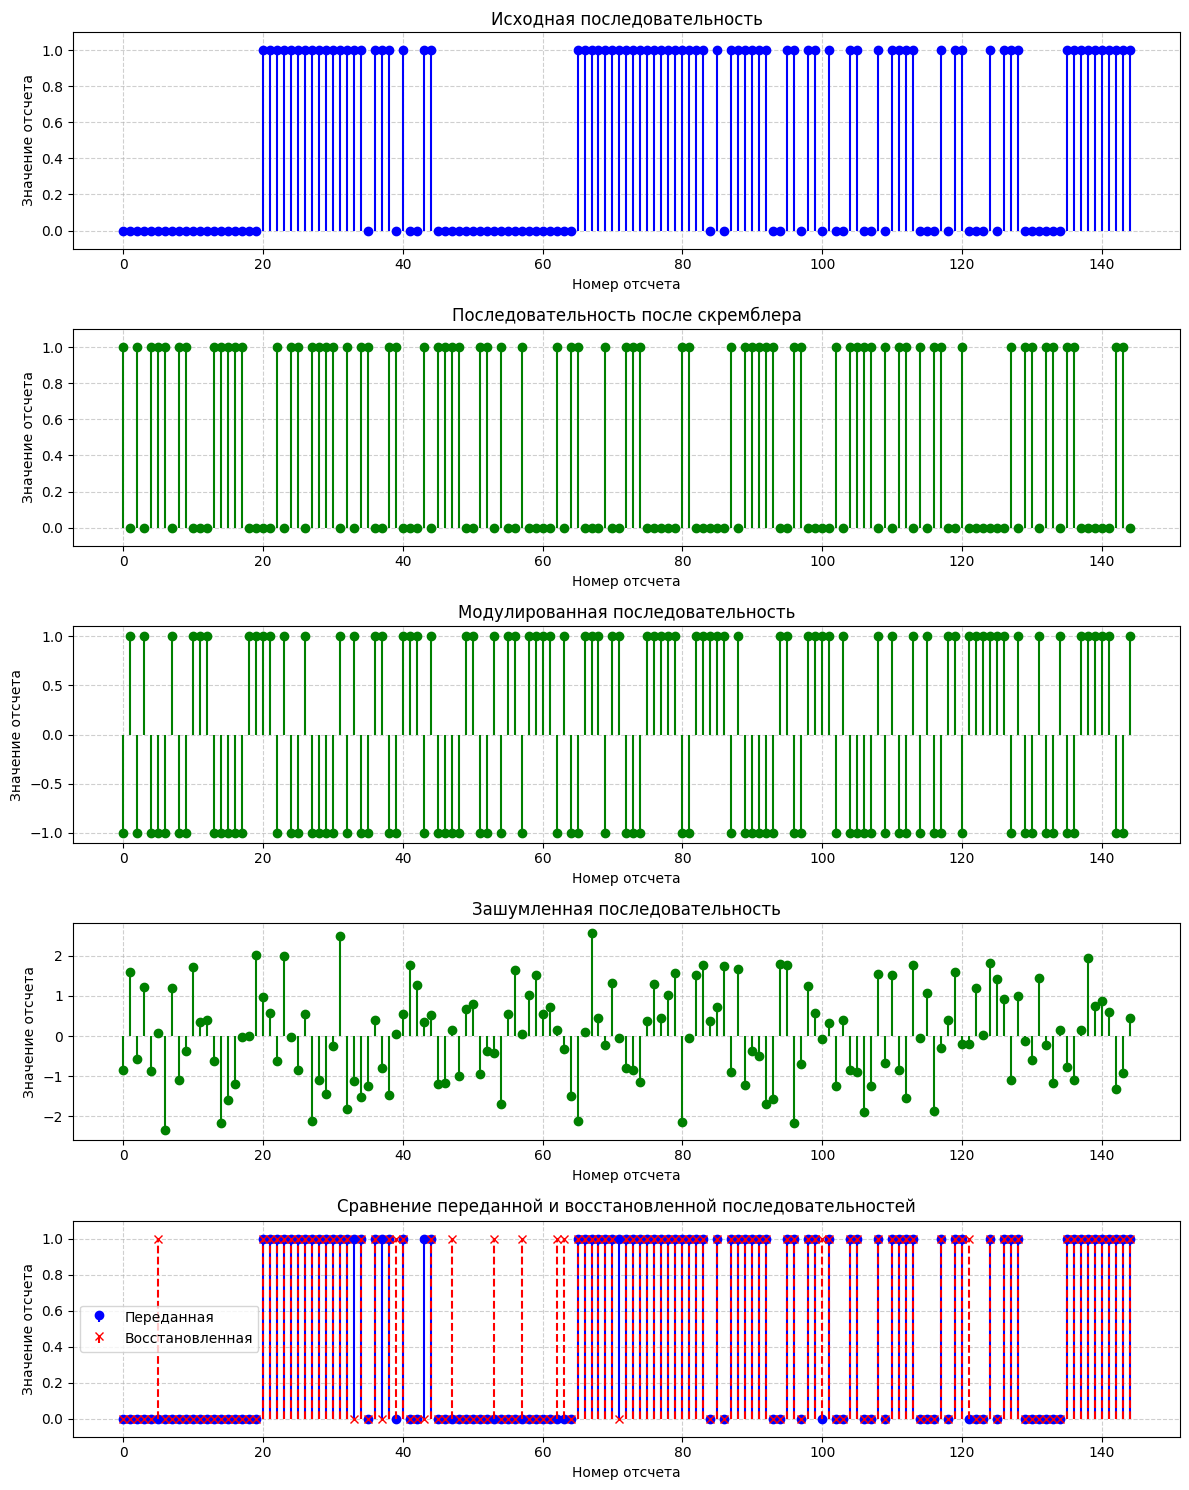

In [70]:
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return complex_noise

block_zeros = np.zeros(20, dtype=int)  # Блок из 20 нулей
block_ones = np.ones(15, dtype=int)    # Блок из 15 единиц
random_part = np.random.randint(0, 2, 50)  # Случайные биты


data_2 = np.concatenate([
    block_zeros,
    block_ones,
    np.random.randint(0, 2, 10),  
    block_zeros,
    block_ones,
    random_part,
    block_zeros[-5:],  
    np.ones(10)        
])[:200]  


SNR = [20, 10, 5, 1, 0]
for snr in SNR:
    gen_poly = np.array([5, 3, 0])  
    init_state = np.array(np.hstack([np.zeros(np.max(gen_poly) - 1), 1]), dtype=int)  

    data = data_2

    scrambled_data = scrambler_descrambler(gen_poly, init_state, data)
    mod_data = 1 - 2*scrambled_data
    awgn_noise = awgn(mod_data, snr)
    tx = mod_data + awgn_noise
    demod_data = 1*(tx <= 0)
    descrambled_data = scrambler_descrambler(gen_poly, init_state, demod_data)

    plt.figure(figsize=(12, 15))

    plt.subplot(5, 1, 1)
    plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Исходная последовательность')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()

    plt.subplot(5, 1, 2)
    plt.stem(scrambled_data, linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Последовательность после скремблера')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()

    plt.subplot(5, 1, 3)
    plt.stem(mod_data, linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Модулированная последовательность')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    plt.subplot(5, 1, 4)
    plt.stem(tx, linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Зашумленная последовательность')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    plt.subplot(5, 1, 5)
    plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ', label='Переданная')
    plt.stem(descrambled_data, linefmt='r--', markerfmt='rx', basefmt=' ', label='Восстановленная')
    plt.title('Сравнение переданной и восстановленной последовательностей')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()
    plt.show()

Полученные графики показывают, что в принятой последовательности обнаруживаются ошибки, начиная со значения snr = 5 и ниже.  
Для сравнения приведены графики без использования скремблера-дескремблера с той же последовательностью.

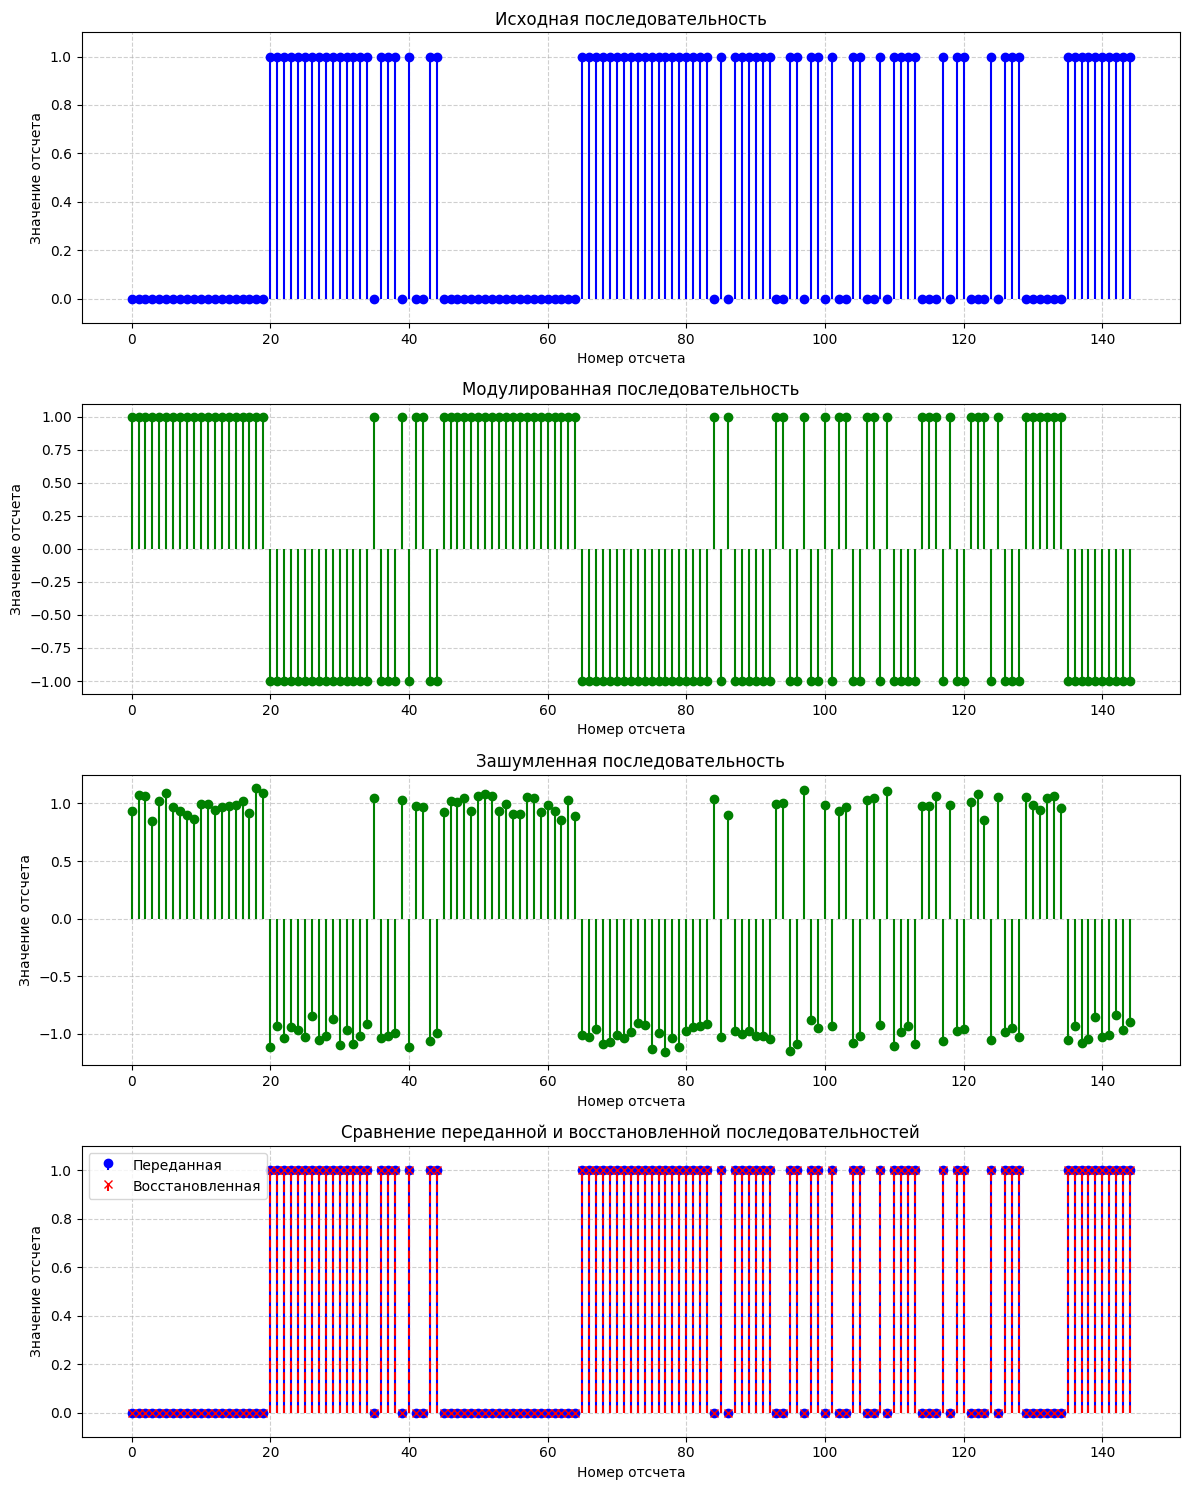

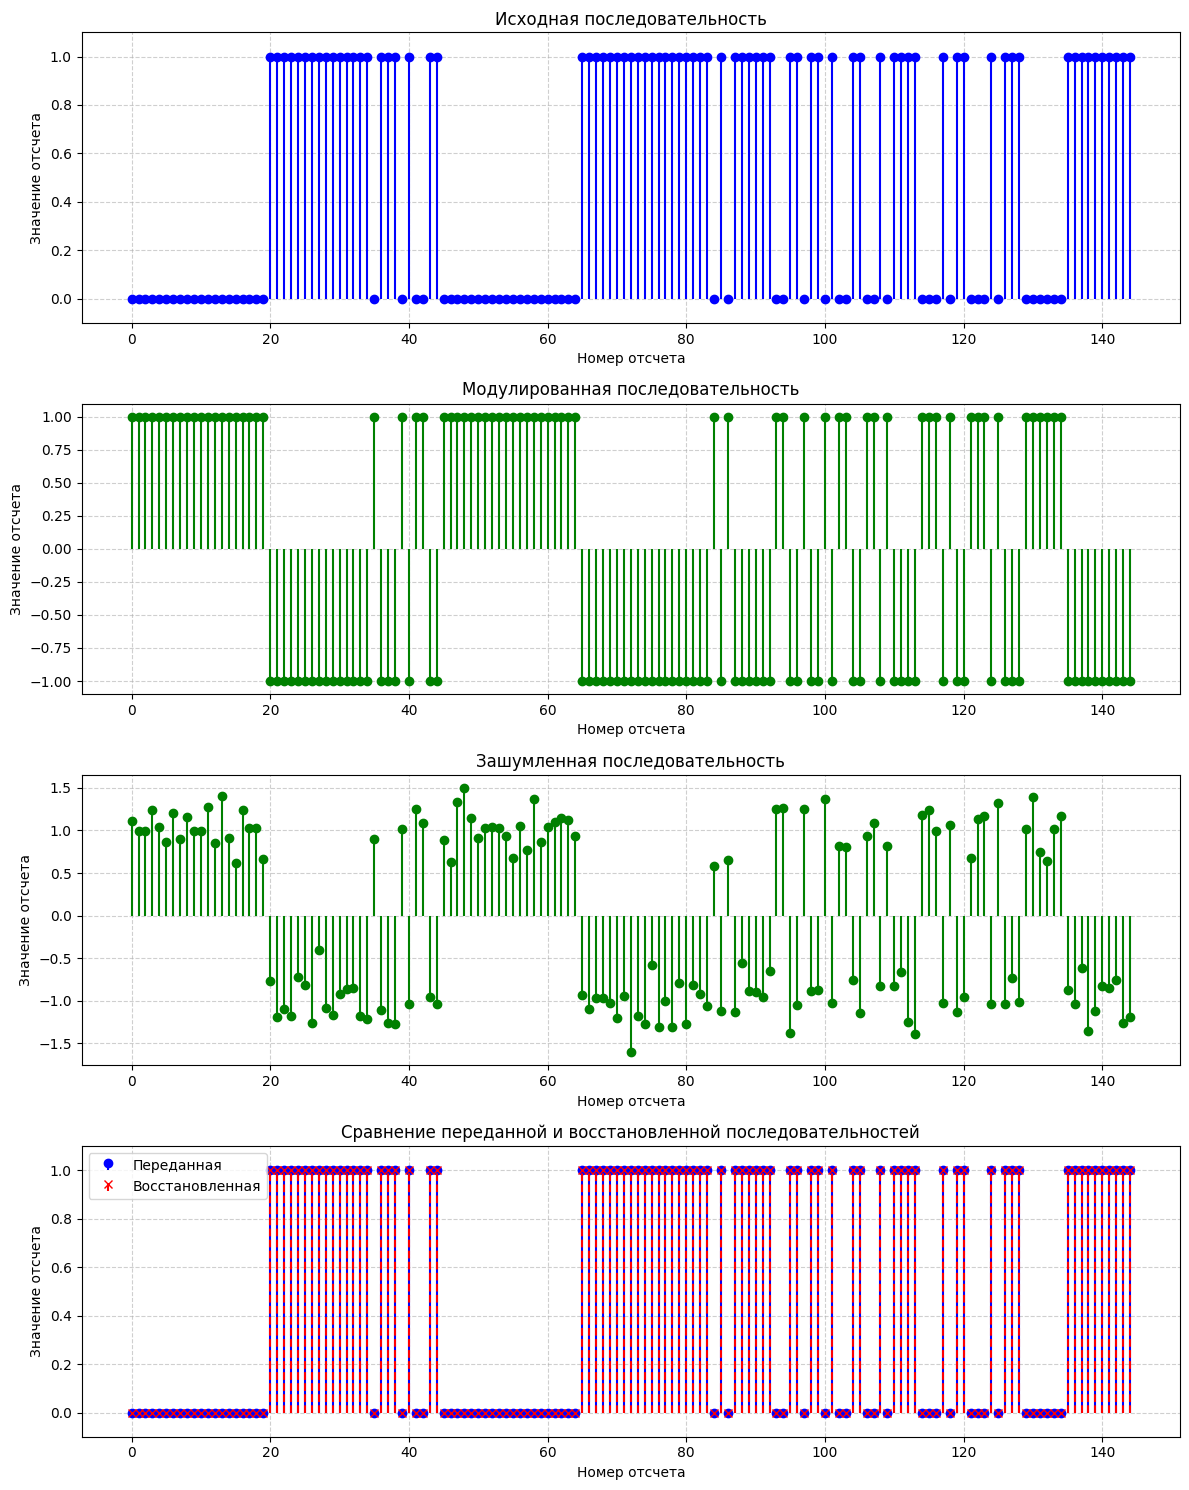

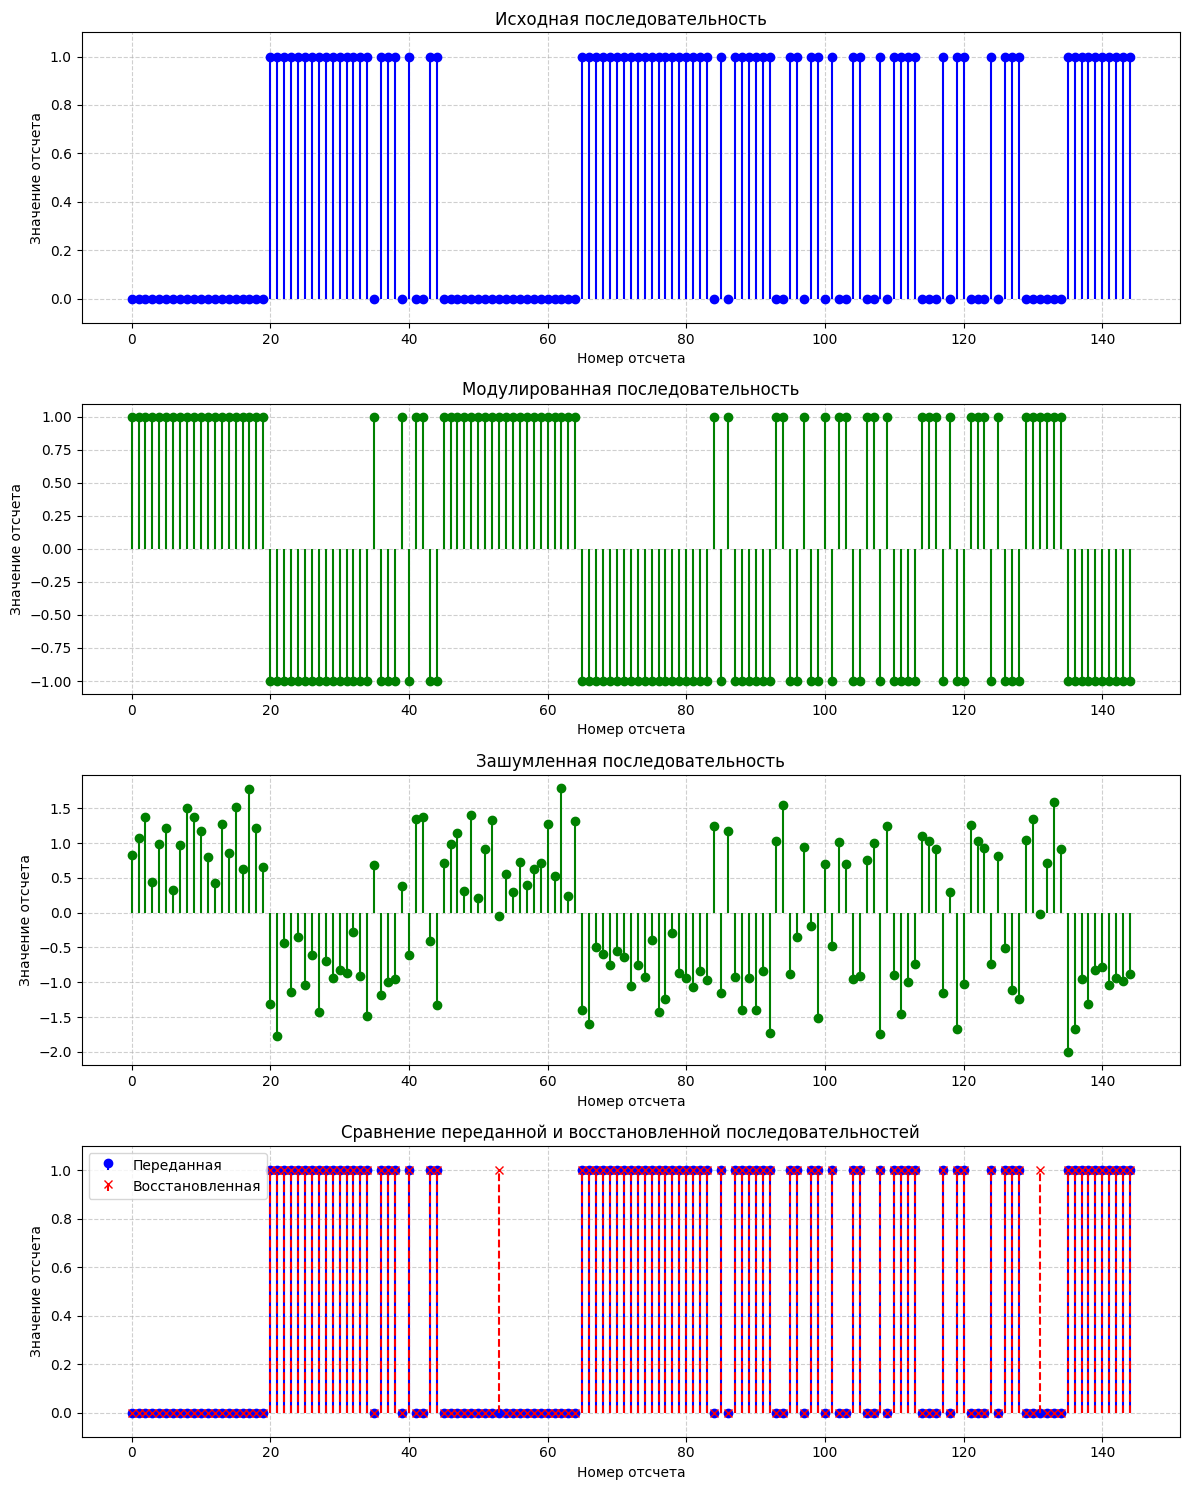

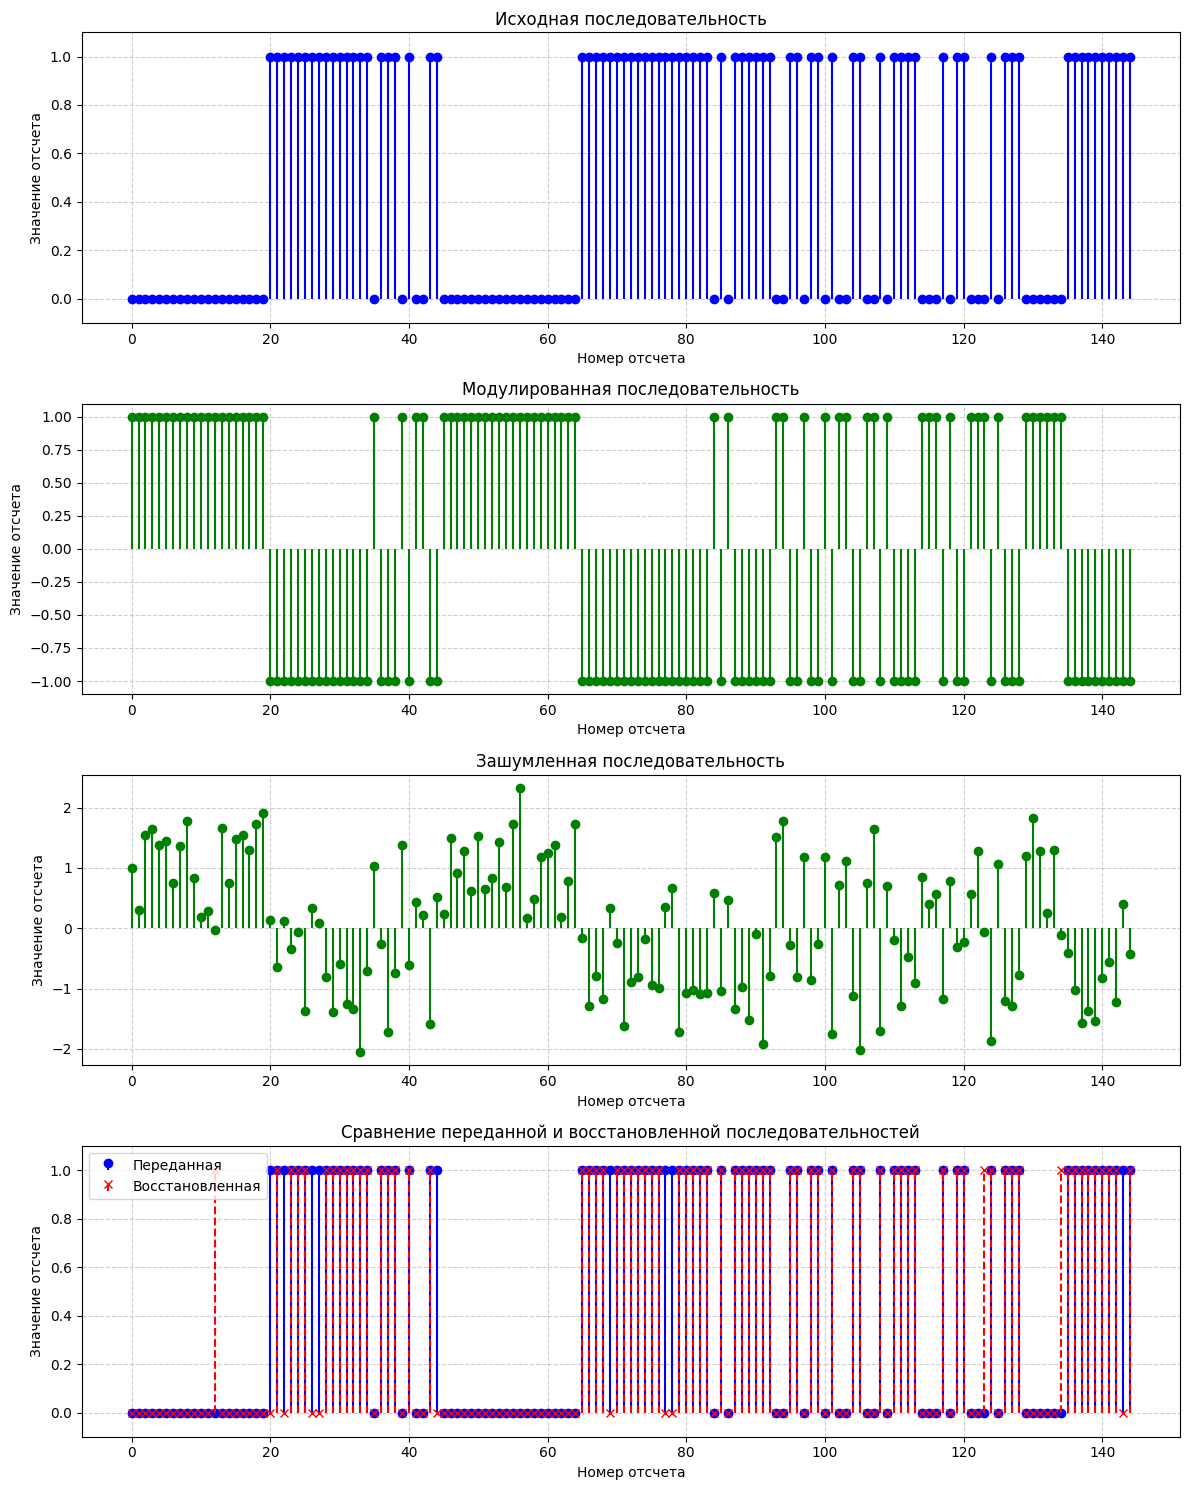

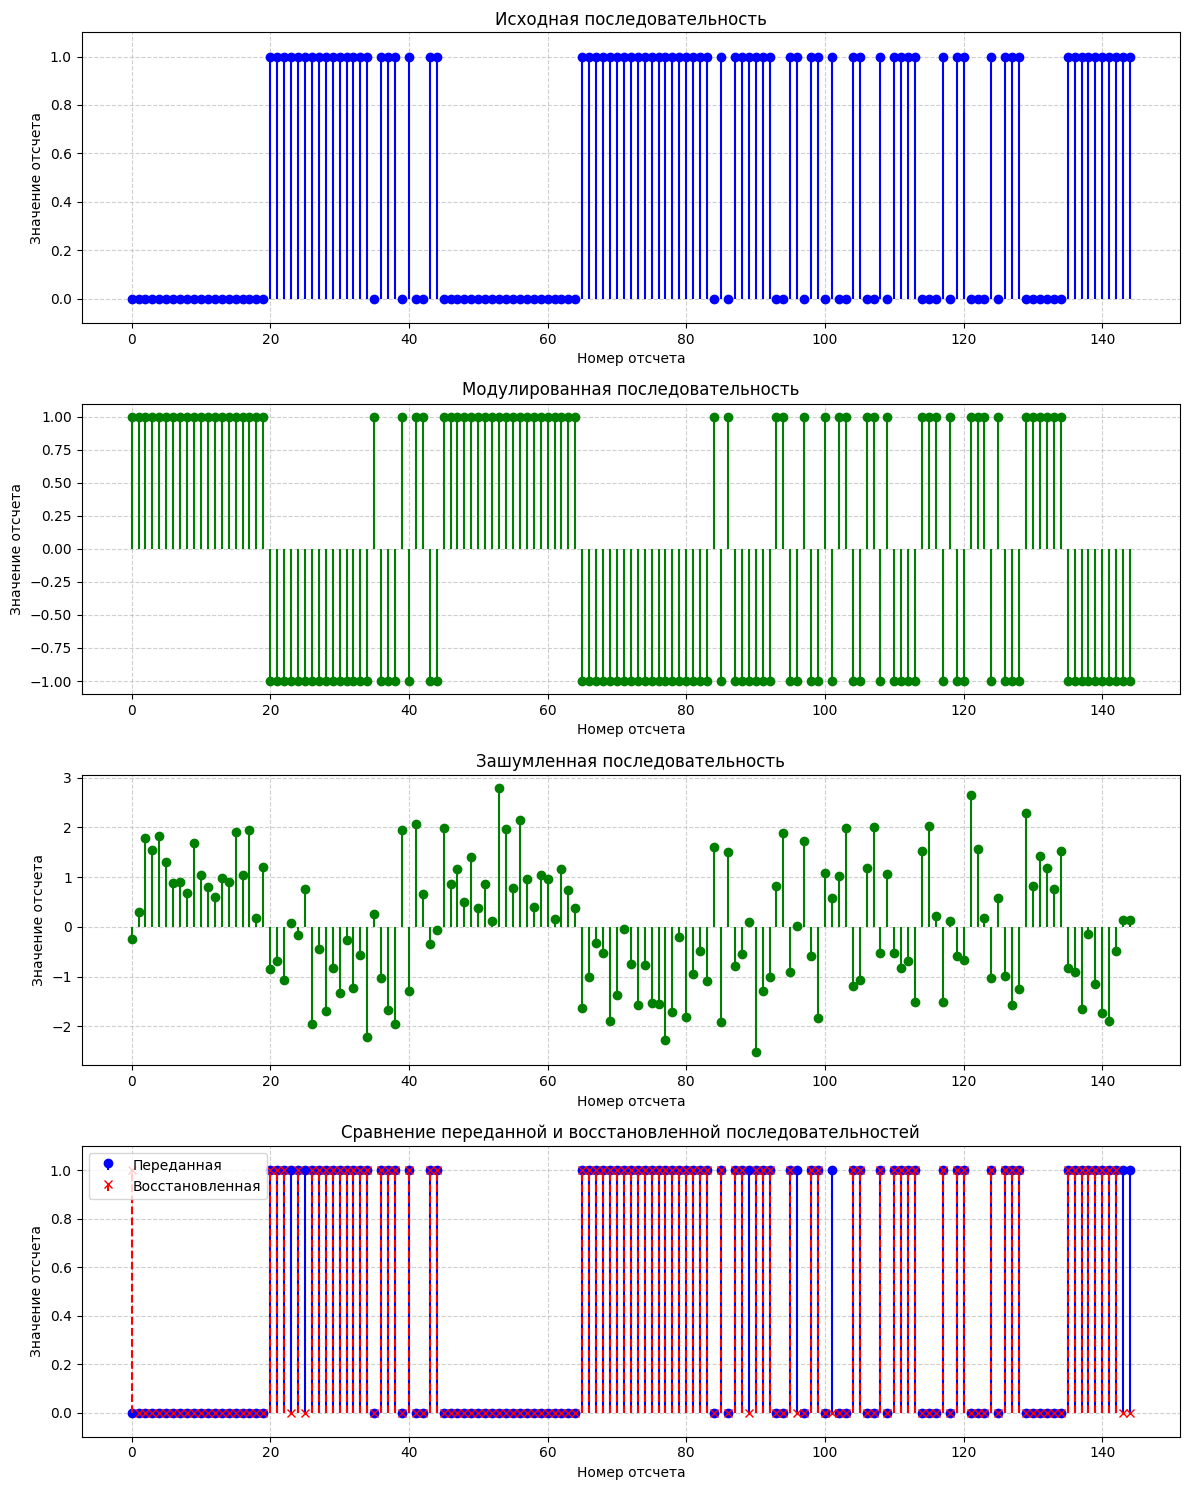

In [71]:
for snr in SNR:
    gen_poly = np.array([5, 3, 0])  
    init_state = np.array(np.hstack([np.zeros(np.max(gen_poly) - 1), 1]), dtype=int)  

    data = data_2

    mod_data = 1 - 2*data
    awgn_noise = awgn(mod_data, snr)
    tx = mod_data + awgn_noise
    demod_data = 1*(tx <= 0)

    plt.figure(figsize=(12, 15))

    plt.subplot(4, 1, 1)
    plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ')
    plt.title('Исходная последовательность')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()

    plt.subplot(4, 1, 2)
    plt.stem(mod_data, linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Модулированная последовательность')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    plt.subplot(4, 1, 3)
    plt.stem(tx, linefmt='g-', markerfmt='go', basefmt=' ')
    plt.title('Зашумленная последовательность')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()

    plt.subplot(4, 1, 4)
    plt.stem(data, linefmt='b-', markerfmt='bo', basefmt=' ', label='Переданная')
    plt.stem(demod_data, linefmt='r--', markerfmt='rx', basefmt=' ', label='Восстановленная')
    plt.title('Сравнение переданной и восстановленной последовательностей')
    plt.xlabel('Номер отсчета')
    plt.ylabel('Значение отсчета')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()
    plt.show()

Таким образом, полученные результаты показывают, что скремблирование не влияет на исправление ошибок последовательности после воздействия канала с шумом.

## Вывод  
В ходе выполнения лабораторной работы был реализован блок регистра сдвига с линейной обратной связью, на основе которого был реализован скремблер-дескремблер. 
Для полученной системы были исследованы зависимости от генераторной последовательности, сравнение результатов при передаче случайной последовательности и последовательности с большим количеством последовательных нулей и единиц, а также было оценено влияние скремблера на исправление ошибок после канала с шумом.  
Проведенные исследования позволили сделать вывод, что 
* скремблер-дескремблер одинаково корректно работает для обоих видов последовательностей (случайной последовательности и последовательности с большим количеством последовательных нулей и единиц)  
* Выбор генератора незначительно влияет на результат работы скремблера-дескремблера, однако наилучшей генераторной последовательностью из исследованных является [5,3,0]  
* Скремблер-дескремблер не влияет на восстановление бит подвергшихся воздействию шума.